### import modules and dataset

In [1]:
import main, cv2, torch, h5py, numpy as np, matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from pathlib import Path
import scipy.sparse as sp

from torchvision import transforms
from PIL import Image

# Try to import CuPy, a NumPy-like array library that runs on NVIDIA GPUs (CUDA).
# If this succeeds, `cp` will refer to CuPy and array operations may be GPU-accelerated
try:
    import cupy as cp
# If CuPy is not installed (or cannot be used on this machine),
# fall back to NumPy but still call it `cp` so downstream code
# can use a unified API (cp.array, cp.linalg, etc.).
except ImportError:
    import numpy as cp
from utils.dataset import DataSet, gamma_correct, gamma_linear
from utils.helper import compute_svd
from models.denoiser import Denoiser
from inverse.solver import RenderMatrix, linear_inverse, DichromatMatrix
from tqdm.notebook import tqdm
import torch

# Check whether PyTorch was built with Apple Metal (MPS) support
# AND whether an Apple GPU is available to use right now.
# This is the preferred option on Apple Silicon (M1/M2/M3/M4)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
# If MPS is not available, check whether an NVIDIA GPU with CUDA is available
elif torch.cuda.is_available():
    device = torch.device("cuda")  
# If neither Apple MPS nor NVIDIA CUDA is available,
# fall back to running everything on the CPU.
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [2]:
##### load dataset #####
# N = 40
# Specify which dataset to load.
# 'islvrc' refers to the ImageNet / ILSVRC-style dataset stored under utils/dataset/islvrc
# This string is later used inside DataSet.load_dataset(...) to find the correct files.
main.args.data_path = 'islvrc'
# Set the scale factor applied to test images before cropping.
# This typically controls resizing of the image prior to taking a fixed-size crop
# (e.g., resize image to ~38.5% of original size, then extract a 128x128 patch).
main.args.test_scale = [0.385]
# DataSet.load_dataset(...) initializes the dataset object using main.args
#    test_mode=True ensures we load test images (not training images)
#   .test_set() returns the test images as a NumPy array
#    [:40] selects only the first 40 images for this demo
test_set = DataSet.load_dataset(main.args, test_mode=True).test_set()[:40]
# Store the number of test images used
n_sample = 40

##### load denoiser #####
# Specify the file path to the pretrained denoiser weights
# This .pt file contains the learned parameters of a CNN denoiser
main.args.model_path = './assets/conv3_ln.pt'
# Initialize the denoiser network architecture.
# The model structure (number of layers, channels, etc.)
# is determined by settings stored in main.args.
model = Denoiser(main.args)
# Load the pretrained weights into the denoiser model.
# torch.load(...) reads the saved parameters from disk
# load_state_dict(...) assigns them to the model’s layers
state = torch.load(main.args.model_path, map_location="cpu")
model.load_state_dict(state)
model.eval()

# model.load_state_dict(torch.load(main.args.model_path))
# model = model.eval()

# Choose whether to run computations on a GPU or CPU.
#   If a CUDA-capable GPU is available, use it ('cuda')
#   Otherwise, fall back to the CPU ('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/var/folders/76/m2c2wk6s4493qj2rt24534c40000gr/T/ipykernel_18744/360511128.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(main.args.model_path, map_

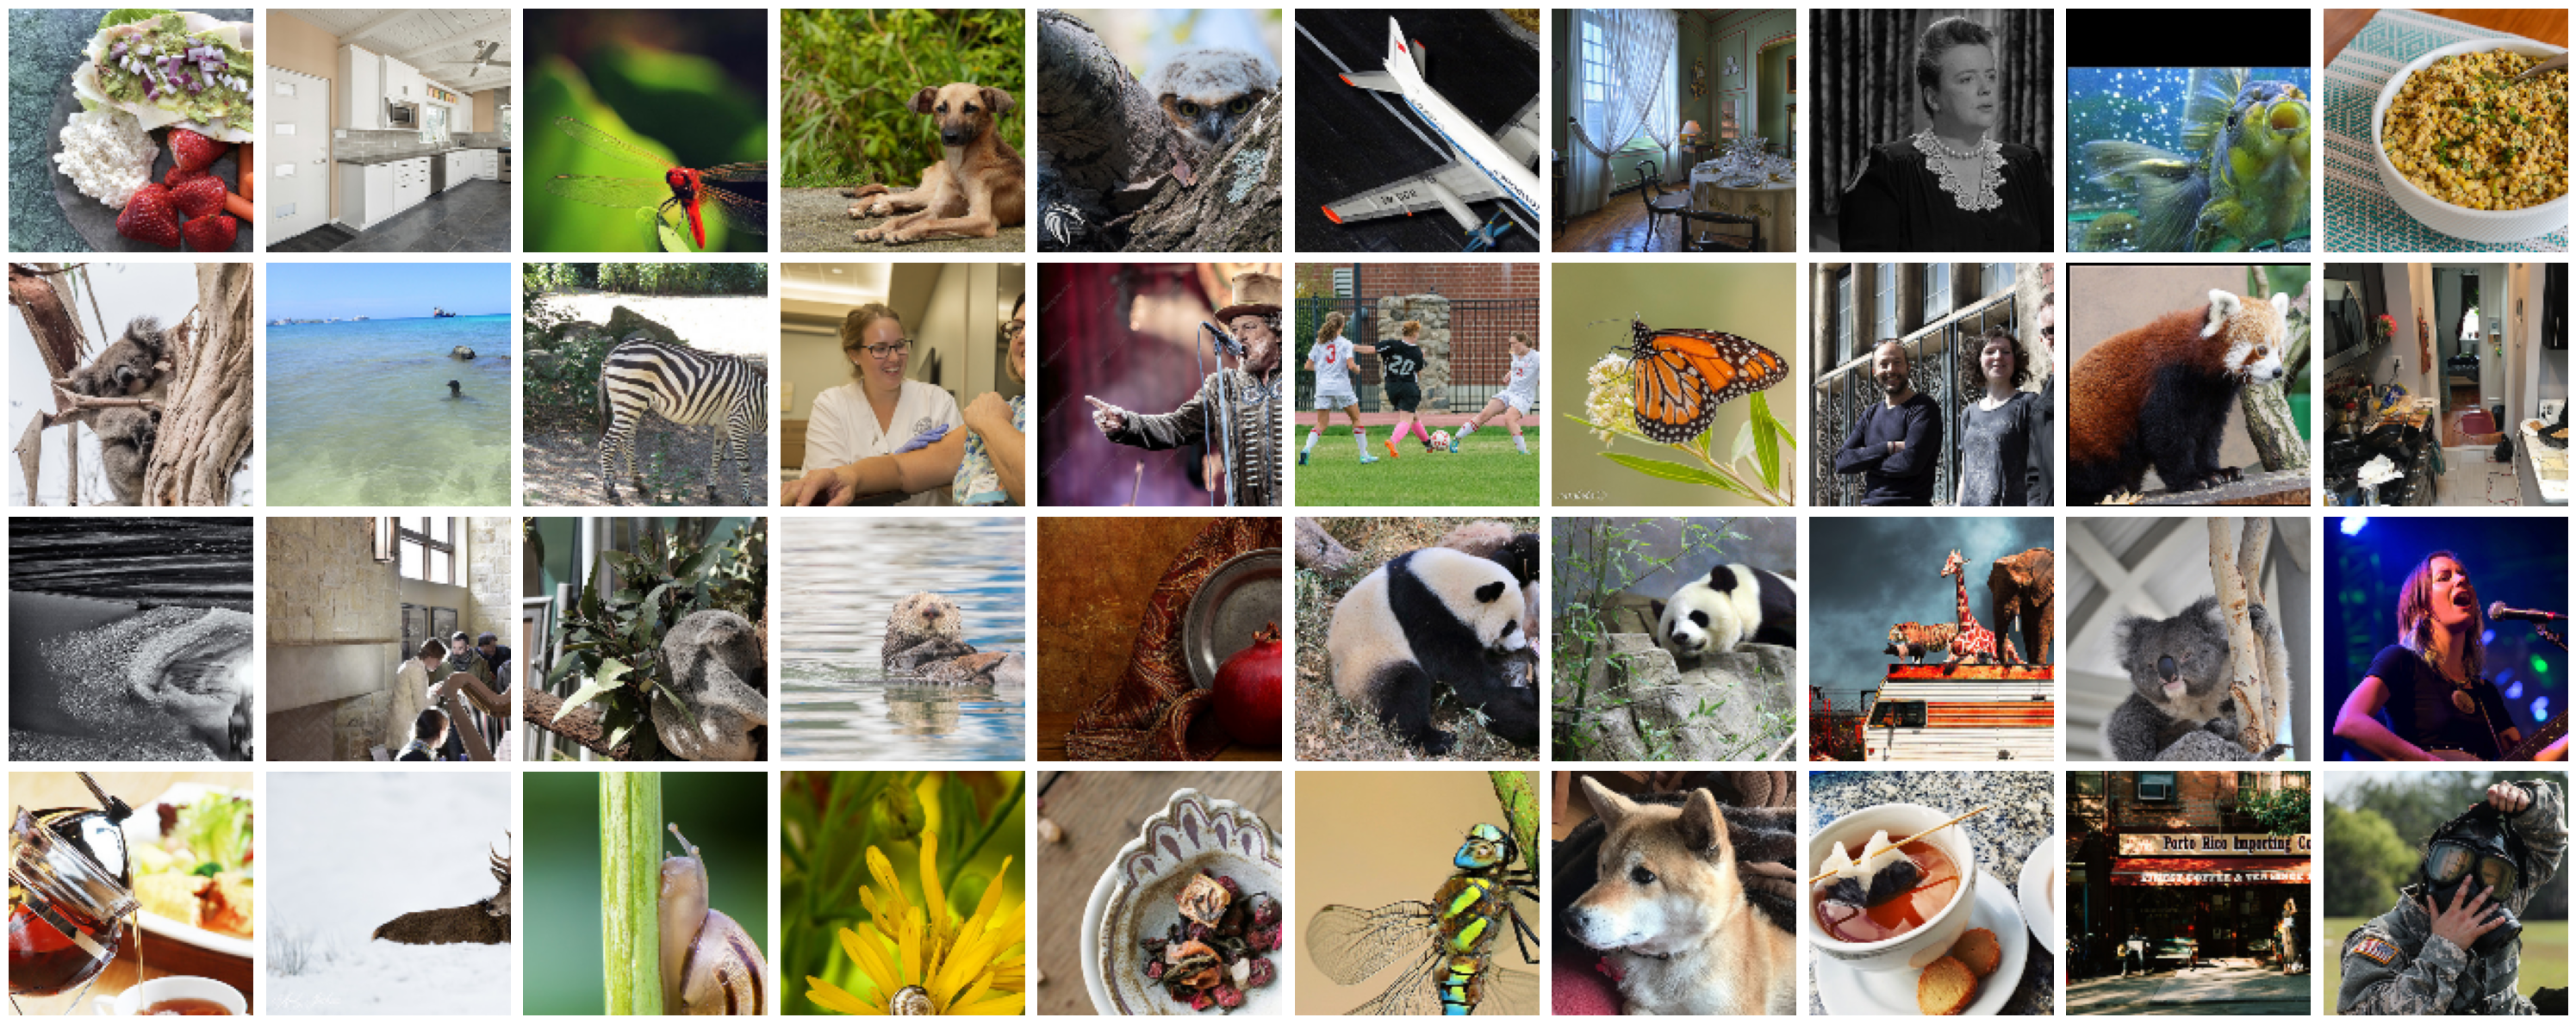

In [3]:
n_row = 4
n_col = 10
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * 3,
                        n_row * 3), sharex=True, sharey=True)

for idx in range(n_row * n_col):
    axs.flat[idx].imshow(gamma_correct(test_set[idx]))
    axs.flat[idx].axis('off')

fig.tight_layout()

### denoising demo

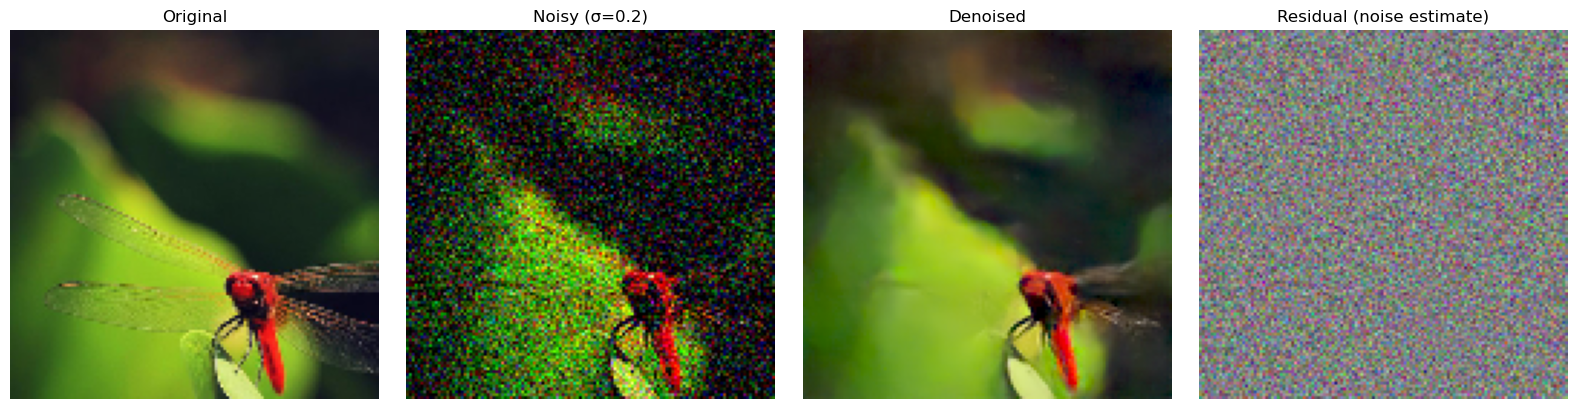

PSNR (noisy): 16.21 dB
PSNR (denoised): 29.66 dB


In [4]:
# Denoising demo: add noise to an image and denoise it
test_idx = 2
# Convert the selected test image from NumPy to a PyTorch tensor
#   test_set[test_idx] has shape (H, W, 3) in NumPy
#   permute([2, 0, 1]) reorders dimensions to (3, H, W),
#   which is the channel-first format expected by PyTorch
#   unsqueeze(0) adds a batch dimension, giving shape (1, 3, H, W)
#   to(device) moves the tensor to CPU or GPU depending on availability
test_img = torch.tensor(test_set[test_idx]).permute([2, 0, 1]).unsqueeze(0).to(device)

# Add Gaussian noise
noise_level = 0.2 # standard deviation of the Gaussian 
# Generate random Gaussian noise with the same shape as test_img.
#   torch.randn_like(test_img) draws samples from N(0, 1)
#   multiplying by noise_level scales the noise variance
#   adding it to test_img produces a noisy observation
noisy_img = test_img + torch.randn_like(test_img).to(device) * noise_level

###### Denoise using the model (model predicts residual/noise) ######
# Ensure the denoiser model itself is on the same device as the data
model = model.to(device)
# Disable gradient tracking since we are only doing inference,
# not training or backpropagation
with torch.no_grad():
    # Run the noisy image through the denoiser
    # Ask the model to look at the noisy image and point out
    # which parts of it do NOT look like a real, natural image.
    # The output has the same shape as the image and highlights
    # the grainy / speckly / unnatural stuff that should be removed.
    residual = model(noisy_img)
    # Clean the image by literally subtracting away the parts
    # that the model thinks do not belong.
    # What remains is the model’s best guess of what the original,
    # clean image probably looked like.
    denoised_img = noisy_img - residual

# Convert to numpy for visualization
original_np = test_img.squeeze(0).permute([1, 2, 0]).cpu().numpy()
noisy_np    = noisy_img.squeeze(0).permute([1, 2, 0]).cpu().numpy()
denoised_np = denoised_img.squeeze(0).permute([1, 2, 0]).cpu().numpy()
residual_np = residual.squeeze(0).permute([1, 2, 0]).cpu().numpy()

# Normalize residual for visualization
# because it initially has positive and negative values
residual_np = (residual_np - residual_np.min()) / (residual_np.max() - residual_np.min())

# Plot
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(gamma_correct(np.clip(original_np, 0, 1)))
axs[0].set_title('Original')
axs[1].imshow(np.clip(noisy_np, 0, 1))
axs[1].set_title(f'Noisy (σ={noise_level})')
axs[2].imshow(gamma_correct(np.clip(denoised_np, 0, 1)))
axs[2].set_title('Denoised')
axs[3].imshow(residual_np)
axs[3].set_title('Residual (noise estimate)')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Print PSNR
from skimage.metrics import peak_signal_noise_ratio as psnr
print(f"PSNR (noisy): {psnr(original_np, np.clip(noisy_np, 0, 1)):.2f} dB")
print(f"PSNR (denoised): {psnr(original_np, np.clip(denoised_np, 0, 1)):.2f} dB")

### reconstruction demo

In [5]:
# Random sampling matrix reconstruction demo (WE WILL WANT THIS TO BE NOT RANDOM... BUT RATHER DICHROMAT)

# Original image dimensions
im_dim = 128 * 128 * 3  # 49152
# Measurement dimensions
msmt_dim = im_dim // 20  # (5% of original)

# Create random matrix and orthogonalize using SVD
print(f'Creating random {msmt_dim} x {im_dim} measurement matrix...')
np.random.seed(42)
# Create a random Gaussian measurement matrix.
#   Each row represents one linear measurement
#   Each column corresponds to one pixel/channel in the flattened image
#   Values are drawn from a standard normal distribution
#   (2457, 49152) which is K x 3N
random_mtx = np.random.randn(msmt_dim, im_dim).astype(np.float32)
print(f'Random matrix shape: {random_mtx.shape}')

# Orthogonalize rows using SVD (make rows orthonormal)
# This decomposes the matrix as:
#   random_mtx = U @ diag(S) @ Vt
# where:
#   U has orthonormal columns
#   Vt has orthonormal rows
#   S contains singular values
U, S, Vt = np.linalg.svd(random_mtx, full_matrices=False)
# U @ Vt gives orthonormal rows
ortho_mtx = (U @ Vt).astype(np.float32)

# K X 3N 
print(f'Orthogonalized matrix shape: {ortho_mtx.shape}')

# Verify orthogonality: R @ R.T should be identity
identity_check = ortho_mtx @ ortho_mtx.T
print(f'Orthogonality check (should be ~1.0): {np.diag(identity_check).mean():.4f}')

Creating random 2457 x 49152 measurement matrix...
Random matrix shape: (2457, 49152)
Orthogonalized matrix shape: (2457, 49152)
Orthogonality check (should be ~1.0): 1.0000


In [ ]:
# Notebook root (ColorCorrection/)
ROOT = Path.cwd()

# conversion_mats directory
MAT_DIR = ROOT / "conversion_mats"

# Load matrices
T_cones = loadmat(MAT_DIR / "T_cones.mat")["T_cones"]        # Spectral sensitivities
P_monitor = loadmat(MAT_DIR / "P_monitor.mat")["P_monitor"]  # Monitor primaries

print("T_cones:", T_cones.shape)       # expect (3, 31)
print("P_monitor:", P_monitor.shape)   # expect (31, 3)

# Build matrix that takes in RGB then does the operation:
# RGB -> LMS_trichromat -> LMS_dichromat
# Step 1: build matrix that takes in RGB and converts to LMS
rgb2lms = T_cones @ P_monitor
# print(rgb2lms.shape)   # (3, 3)
# print(rgb2lms)

# Step 2: build matrix that takes only the rows of LMS that the dichromat has
dichromatType = "deuteranopia"
if dichromatType.lower() == "deuteranopia":
    # Missing M cone, keep L and S
    lms2di = np.array([
        [1, 0, 0],  # L
        [0, 0, 1],  # S
    ])

elif dichromatType.lower() == "protanopia":
    # Missing L cone, keep M and S
    lms2di = np.array([
        [0, 1, 0],  # M
        [0, 0, 1],  # S
    ])

elif dichromatType.lower() == "tritanopia":
    # Missing S cone, keep L and M
    lms2di = np.array([
        [1, 0, 0],  # L
        [0, 1, 0],  # M
    ])

else:
    raise ValueError(f"Unknown dichromatType: {dichromatType}")

# 2 x 3 matrix
rgb2di = lms2di @ rgb2lms

nPixels = 128 * 128
# Preallocate matrix
M = np.zeros((2 * nPixels, 3 * nPixels))

# Loop through each pixel value to create a 2N X 3N matrix consisting of vals above
# for pp in range(nPixels):
#     # First row block 
#     M[pp, pp]               = rgb2di[0, 0]
#     M[pp, pp + nPixels]     = rgb2di[0, 1]
#     M[pp, pp + 2*nPixels]   = rgb2di[0, 2]

#     # Second row block
#     M[pp + nPixels, pp]             = rgb2di[1, 0]
#     M[pp + nPixels, pp + nPixels]   = rgb2di[1, 1]
#     M[pp + nPixels, pp + 2*nPixels] = rgb2di[1, 2]

# print("M:", M.shape)

# Orthonormalize this matrix 
# U, S, Vt = np.linalg.svd(M, full_matrices=False)

U, S, Vt = np.linalg.svd(rgb2di, full_matrices=False)
# U @ Vt gives orthonormal rows
ortho_mtx = (U @ Vt).astype(np.float32)

# Verify orthogonality: R @ R.T should be identity
identity_check = ortho_mtx @ ortho_mtx.T
print(f'Orthogonality check (should be ~1.0): {np.diag(identity_check).mean():.4f}')



In [10]:
# Run reconstruction with the random sampling matrix
test_set_torch = torch.tensor(test_set).permute([0, 3, 1, 2]).to(device)
im_size = test_set_torch.size()[1:]

# Create RenderMatrix with our orthogonalized random matrix
# ortho_mtx is a K × (3N) matrix that expects a flattened image vector
# RenderMatrix handles reshaping (3, H, W) to (3N,) in order to apply the measurement matrix
render = RenderMatrix(torch.tensor(ortho_mtx), im_size, device)
A = torch.tensor(ortho_mtx, dtype=torch.float32, device=device)
# render = DichromatMatrix(A, im_size, device)

# Select a test image
test_idx = 2
test_img = test_set_torch[test_idx]

############## Try our own image ##############
# img_dir = ROOT / "dichromat_images"
# img_path = img_dir / "gaugin.png"

# # 1) Load with PIL (still gamma-encoded display RGB typically)
# img = Image.open(img_path).convert("RGB")

# # 2) Convert to float in [0,1] as an HxWx3 numpy array
# img_np = np.asarray(img).astype(np.float32) / 255.0   # (H,W,3), [0,1]

# # 3) Reverse gamma correct (decode to linear light)
# img_lin = gamma_linear(img_np)                        # (H,W,3), [~0,1] linear
# img_lin = np.clip(img_lin, 0.0, 1.0)

# # 4) Convert to torch tensor in CHW
# test_img = torch.from_numpy(img_lin).permute(2, 0, 1) # (3,H,W)

# # 5) Move to same device/dtype as your dataset/model
# test_img = test_img.to(device=test_set_torch.device, dtype=test_set_torch.dtype)

########################################################
print(f'Test image shape: {test_img.shape}')

# Create measurement
# Internally, RenderMatrix.measure():
#   1. Flattens the image into a vector of length 3N
#   2. Multiplies by the measurement matrix (K × 3N)
#   3. Returns a flat measurement vector of length K
msmt = render.measure(test_img)
print(f'Measurement shape: {msmt.shape}')

# Run reconstruction
print('Running reconstruction...')
recon_result = linear_inverse(model, render, msmt, stride=40)

Test image shape: torch.Size([3, 128, 128])
Measurement shape: torch.Size([2457])
Running reconstruction...

[DEBUG] Entering linear_inverse
[DEBUG] input.dim(): 1
[DEBUG] input measurement shape: (2457,)


UnboundLocalError: cannot access local variable 'R_T' where it is not associated with a value

In [ ]:
# Visualize original vs reconstruction
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Original image
original = test_img.permute([1, 2, 0]).cpu().numpy()
axs[0].imshow(gamma_correct(np.clip(original, 0, 1)))
axs[0].set_title('Original')
axs[0].axis('off')

# Reconstructed image
reconstructed = recon_result[-1]
axs[1].imshow(gamma_correct(np.clip(reconstructed, 0, 1)))
axs[1].set_title('Reconstructed (from 5% measurements)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Run reconstruction on multiple images and visualize together
n_examples = 6
# example_indices = [0, 5, 10, 15, 20, 25]
example_indices = [1, 6, 11, 16, 21, 26]
# example_indices = [1, 6, 11, 16, 21, 26, 0, 5, 10, 15, 20, 25]

fig, axs = plt.subplots(2, n_examples, figsize=(3 * n_examples, 6))

for i, idx in enumerate(example_indices):
    test_img = test_set_torch[idx]

    # Measure and reconstruct
    msmt = render.measure(test_img)
    recon = linear_inverse(model, render, msmt, stride=0)[-1]

    # Original
    original = test_img.permute([1, 2, 0]).cpu().numpy()
    axs[0, i].imshow(gamma_correct(np.clip(original, 0, 1)))
    axs[0, i].set_title(f'Original {idx}')
    axs[0, i].axis('off')

    # Reconstruction
    axs[1, i].imshow(gamma_correct(np.clip(recon, 0, 1)))
    axs[1, i].set_title('Reconstructed')
    axs[1, i].axis('off')

plt.suptitle(f'Reconstruction from {msmt_dim/im_dim*100:.0f}% measurements', fontsize=14)
plt.tight_layout()
plt.show()

### basic reconstruction routine

In [ ]:
def run_recon(render, denoiser, test_set):
    test_set_torch = torch.tensor(test_set).permute([0, 3, 1, 2]).to(device)

    im_size = test_set_torch.size()[1:]
    render = RenderMatrix(torch.tensor(render.astype('float32')),
                          im_size, device)

    recon_error = []
    for idx in tqdm(range(n_sample)):
        test = test_set_torch[idx]
        gt = test.permute([1, 2, 0]).cpu().numpy().flatten()

        msmt = render.measure(test)
        recon = linear_inverse(denoiser, render, msmt, stride=0)[-1]

        recon_error.append(np.linalg.norm(recon.flatten() - gt))

    return recon_error

### dichromacy

In [ ]:
def show_recon(render, denoiser, test_set):
    test_set_torch = torch.tensor(test_set).permute([0, 3, 1, 2]).to(device)

    im_size = test_set_torch.size()[1:]
    render = RenderMatrix(torch.tensor(render.astype('float32')),
                          im_size, device)

    fig, axs = plt.subplots(8, 5, figsize=(15, 24), sharex=True, sharey=True)
    all_recon = []
    for idx in tqdm(range(n_sample)):
        test = test_set_torch[idx]
        msmt = render.measure(test)
        recon = linear_inverse(denoiser, render, msmt, stride=0)[-1]

        n_avg = 10
        for ct in range(n_avg):
            recon += linear_inverse(denoiser, render, msmt, stride=0)[-1]

        recon /= (n_avg + 1)
        recon = gamma_correct(np.clip(recon, 0, 1))

        axs.flat[idx].imshow(recon)
        axs.flat[idx].axis('off')
        all_recon.append(recon)

    fig.tight_layout()
    return all_recon

In [ ]:
def show_original(render, denoiser, test_set):
    test_set_torch = torch.tensor(test_set).permute([0, 3, 1, 2]).to(device)

    im_size = test_set_torch.size()[1:]
    render = RenderMatrix(torch.tensor(render.astype('float32')),
                          im_size, device)

    fig, axs = plt.subplots(8, 5, figsize=(15, 24), sharex=True, sharey=True)
    all_recon = []
    for idx in tqdm(range(n_sample)):
        test = test_set_torch[idx]
        recon = test.permute([1, 2, 0]).cpu().numpy()
        recon = gamma_correct(np.clip(recon, 0, 1))

        axs.flat[idx].imshow(recon)
        axs.flat[idx].axis('off')
        all_recon.append(recon)

    fig.tight_layout()
    return all_recon

In [ ]:
# with open('./assets/render/render_deg0.npy', 'rb') as data:
#     u = np.load(data)
#     print(u.shape)
# originals = show_original(u.T, model, test_set)

In [ ]:
# file_path = './assets/render/renderProtanopia.mat'
# data = h5py.File(file_path, 'r')
#
# render = np.array(data['renderProtanopia'])
# u, s = compute_svd(render.T)
# protanopia = show_recon(u[s > 1.0, :], model, test_set)

In [ ]:
# file_path = './assets/render/renderDeuteranopia.mat'
# data = h5py.File(file_path, 'r')
#
# render = np.array(data['renderDeuteranopia'])
# u, s = compute_svd(render.T)
# deuteranopia = show_recon(u[s > 1.0, :], model, test_set)

In [ ]:
# file_path = './assets/render/renderTritanopia.mat'
# data = h5py.File(file_path, 'r')
#
# render = np.array(data['renderTritanopia'])
# u, s = compute_svd(render.T)
# tritanopia = show_recon(u[s > 1.0, :], model, test_set)